In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})

import numpy as np
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import math

import nltk
from nltk.corpus import stopwords
import string
from string import punctuation


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
#from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from wordcloud import WordCloud, ImageColorGenerator



In [48]:
reviews = pd.read_csv('D:/SEM6/DS AI/lab/LAB EVAL/Book1.csv')

In [20]:
#data cleaning
reviews = reviews.drop(['UserId', 'ProfileName'], axis=1)

In [21]:
#fill nan
reviews.dropna(inplace=True)

Duplicated values: False    199
dtype: int64


In [22]:
#cleaning
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

reviews['review'] = reviews['Text'].apply(get_text_processing)
reviews.head()

,Id,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,review
0,1,B001E4KFG0,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several Vitality canned dog food produc...
1,2,B00813GRG4,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanutsth...
2,3,B000LQOCH0,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient Robitussin believe f...
4,5,B006K2ZZ7K,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy great price wide assortment yummy ...


In [49]:
#definition of sentiments
reviews['sentiment'] = reviews['Score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


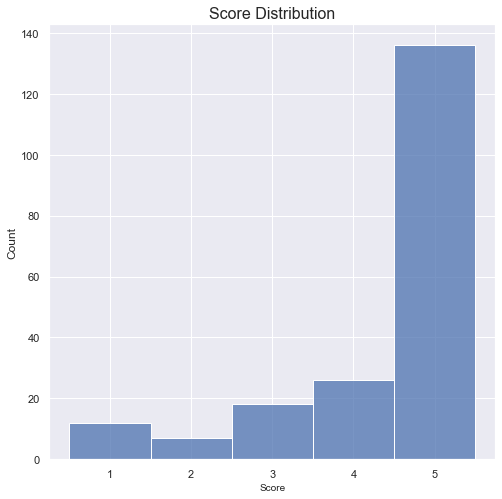

In [50]:
ax = sns.histplot(reviews, x="Score", discrete=True)
ax.set_xlabel( "Score" , size = 10 )
ax.set_ylabel("Count")
  
ax.set_title("Score Distribution" , size = 16 )

plt.show()

In [51]:
reviews = reviews[['Text', 'sentiment']]
reviews.head()

,Text,sentiment
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,negative
4,Great taffy at a great price. There was a wid...,positive


In [53]:
#word clouds
# Create stopword list:
stop_words = ENGLISH_STOP_WORDS.union(["br","href", 'http', 'just', 'amazon', 'product','time','year', 'tried','I\'ve'])

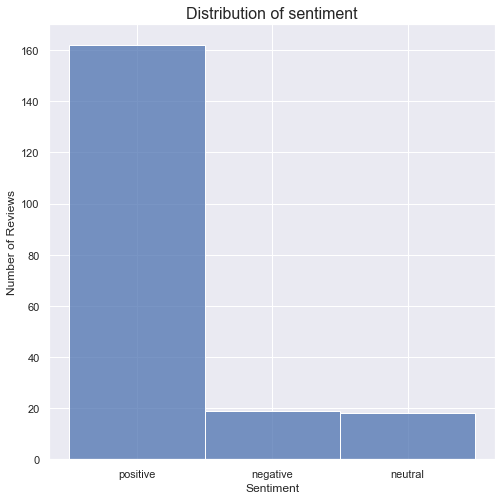

In [52]:
#Definition of sentiments
ax = sns.histplot(reviews, x='sentiment', discrete=True)

ax.set_xlabel( "Sentiment" , size = 12 )
ax.set_ylabel("Number of Reviews")
  
ax.set_title("Distribution of sentiment" , size = 16 )

plt.show()

In [36]:
#Looking for unique words for each sentiment
sentiment = reviews.sentiment.unique()

#create a list of responses for each sentiment using a list comprehension
corpus = [' '.join(reviews[(reviews.sentiment==sent)].Text.tolist()) for sent in sentiment]

cv=CountVectorizer( stop_words=stop_words, ngram_range=(1, 3))

# fit transform text and create a dataframe bag of words with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow=pd.DataFrame(X, columns = cv.get_feature_names())
bow.index=sentiment

#build an empty dataframe
t_bow_df=pd.DataFrame()

# By sentiment, divide the number of times a word is said, 
# by the total number of times they've said all the words that they have said (frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for sent in sentiment:
    feat_s = bow[bow.index != sent].sum()+1 #sum all the times each word was said excluding the sent
    feat_s_all = np.sum(bow[bow.index != sent].sum()) # all the total words that were said, excluding the sent
    tot = feat_s / feat_s_all #find the frequency of words said among other sent
    row = bow_transformed.loc[sent] / tot #divide the candidate's array of frequency of words by all other sent' frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[sent])]) #append 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ve'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [39]:
#Building the model
X_train, X_test, y_train, y_test = train_test_split(reviews.Text, reviews.sentiment, train_size=0.80)
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [47]:
#Model training
trainedforest = RandomForestClassifier(criterion = 'gini',
                                       max_depth = 50,  
                                       n_estimators = 100,
                                       class_weight = 'balanced',
                                       oob_score = True,
                                       n_jobs = -1
                                      ).fit(X_train,y_train)


predictionforest = trainedforest.predict(X_test)

matrix = confusion_matrix(y_test,predictionforest)

print(matrix)
clas_report=classification_report(y_test,predictionforest)
print(clas_report)
acc5 = accuracy_score(y_test,predictionforest)
print('overall accuracy: ' + str(acc5))

[[ 0  0  3]
 [ 0  0  2]
 [ 0  0 35]]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.00      0.00      0.00         2
    positive       0.88      1.00      0.93        35

    accuracy                           0.88        40
   macro avg       0.29      0.33      0.31        40
weighted avg       0.77      0.88      0.82        40

overall accuracy: 0.875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
